# practicalMixGaussC

The goal of this part of the lab is to fit a mixture of gaussians model to some multi-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

Note that you should not use multivariate_normal.pdf for calculating likelihood.

You should use this template for your code and fill in the missing 
sections marked "TO DO."



In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

flt_min = sys.float_info.min

%matplotlib inline

## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our grounf truth mixture of $k$ Gaussians model. We will represent the 
mixtures of Gaussians as a python dictionary. The mean field is a $d \times k$ matrix and the cov field is a 
$d \times d \times k$ matrix.

In [2]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 3
mixGaussTrue['d'] = 2
mixGaussTrue['weight'] = np.array([0.1309, 0.3966, 0.4725])
mixGaussTrue['mean'] = np.array([[ 4.0491 , 4.8597],[ 7.7578 , 1.6335],[ 11.9945, 8.9206]]).T
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2))
mixGaussTrue['cov'] = np.zeros(shape=(mixGaussTrue['d'],mixGaussTrue['d'],mixGaussTrue['k']))
mixGaussTrue['cov'][:,:,0] = np.array([[  4.2534, 0.4791], [0.4791, 0.3522]])
mixGaussTrue['cov'][:,:,1] = np.array([[  0.9729, 0.8723],[  0.8723,  2.6317]])
mixGaussTrue['cov'][:,:,2] = np.array([[  0.9886, -1.2244],[ -1.2244, 3.0187]])

In [3]:
mixGaussTrue['cov'][:,:,0]

array([[4.2534, 0.4791],
       [0.4791, 0.3522]])

In [4]:
mixGaussTrue['mean'][:,0].shape

(2,)

**drawEMData2d**, **sampleFromDiscrete**, **getGaussian2SD**, and **drawGaussianOutline** are helper functions.

In [5]:
def sampleFromDiscrete(probDist):     
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """
    nIndex = len(probDist)                                                                 
    while True:                                                                            
        #choose random index                                                               
        r=int(np.floor(np.random.uniform()*nIndex))                                        
        #choose random height                                                              
        randHeight = np.random.uniform()                                                   
        #if height is less than probability value at this point in the                     
        # histogram then select                                                            
        if randHeight<probDist[r]:                                                         
            break                                                                          
    return r                                                                               

In [6]:
def getGaussian2SD(m,s,angle1):
    """
    Find position of in xy co-ordinates at 2SD out for a certain angle.
    """
  
    if s.shape[1] == 1:
        s = diag(s)

    vec = np.array([np.cos(angle1), np.sin(angle1)])
    
    factor = 4/(vec@np.linalg.inv(s)@vec.T)
    
    x = np.cos(angle1) * np.sqrt(factor)
    y = np.sin(angle1) * np.sqrt(factor)

    x = x + m[0]
    y = y + m[1]
                
    return x,y

In [7]:
def drawGaussianOutline(m,s,w):
    """
    Draw 2DGaussian
    """
    angleInc = 0.1    
    c = (0.9*(1-w), 0, 0)

    for cAngle in np.arange(0,2*np.pi,angleInc):         
        angle1 = cAngle
        angle2 = cAngle+angleInc
        x1, y1 = getGaussian2SD(m,s,angle1)
        x2, y2 = getGaussian2SD(m,s,angle2)
        plt.plot([x1, x2],[y1, y2],'-',linewidth=2,color=c)                 
    return

In [8]:
def drawEMData2d(data,mixGauss):
    """
    Plot the data plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- d by n matrix of data points.
    mixGauss -- dict with mixture of gaussian information.
    
    """
    #set(gcf,'Color',[1 1 1])
    plt.cla() 
    plt.plot(data[0,:],data[1,:],'k.')

    for cGauss in range(mixGauss['k']):
        drawGaussianOutline(mixGauss['mean'][:,cGauss],mixGauss['cov'][:,:,cGauss],mixGauss['weight'][cGauss])
    
    return     


**TODO HERE:**

Complete the TO DO in this function before moving on.

In [9]:
def mixGaussGen(mixGauss, nData):                                                                              
    """
    Generates data from a d-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- d by nData, generated data points. 
    
    """
    # create space for output data                                                                               
    data = np.zeros(shape=(mixGauss['d'], nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])                                                               
        # draw a sample from the appropriate Gaussian distribution
        data[:, cData] = np.linalg.cholesky(mixGaussTrue['cov'][:,:,h])@np.random.randn(mixGauss['d']).T + mixGaussTrue['mean'][:,h]                                                                          
                
                                                                                                         
    return data

With all the helper functions complete, we can now generate and plot some points from our model. The black points are the generated data points. The circles are what the gaussians look like.

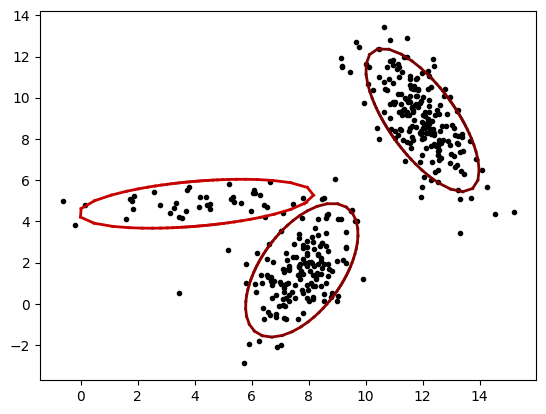

In [10]:
#define number of samples to generate
nData = 400;

#generate data from the mixture of Gaussians
#make sure you've filled in the routine above.
data = mixGaussGen(mixGaussTrue,nData)

#draw data, true Gaussians
drawEMData2d(data,mixGaussTrue)

## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

**TODO HERE:** 

Fill out the missing parts below. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision.

In [11]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDim, nData = data.shape
    k = mixGaussEst['k']
    w = mixGaussEst['weight']
    mean = mixGaussEst['mean']
    cov = mixGaussEst['cov']                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
        # TO DO - calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this
        like = 0
        for i in range(k):                                                          
            like += w[i]*((2*pi)**(-nDim/2)*det(cov[:,:,i])**0.5)**-1 * exp(-0.5*(data[:,cData]-mean[:,i]).T@inv(cov[:,:,i])@(data[:,cData]-mean[:,i]))
        
        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  logLike.item()                                                                       
                                                                                                       

**TODO HERE:** 

Fill out the missing parts below. 

In [12]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDim, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDim
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDim, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDim, nDim, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDim)
        

    # calculate current likelihood
    # TO DO - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 30;

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):
        cov = mixGaussEst['cov']                                                                              
        w = mixGaussEst['weight']                                                                        
        mean = mixGaussEst['mean']
        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            lik = np.zeros(shape=(k))
            liksum = 0
            for i in range(k):
                lik[i] = w[i] * ((2*pi)**(-nDim/2)*det(cov[:,:,i])**0.5)**-1 * exp(-0.5*(data[:,cData]-mean[:,i]).T@inv(cov[:,:,i])@(data[:,cData]-mean[:,i]))
                liksum += lik[i]
                
            postHidden[:, cData] = lik / liksum
            
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            
        # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
        # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :]) / np.sum(postHidden)
            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = (postHidden[cGauss, :]*data).sum(1)/np.sum(postHidden[cGauss, :])
            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            cov = 0
            for cData in range(nData):
                cov += (postHidden[cGauss,cData]*(data[:,cData].reshape(nDim,1)-mixGaussEst['mean'][:,cGauss].reshape(nDim,1))@(data[:,cData].reshape(nDim,1)-mixGaussEst['mean'][:,cGauss].reshape(nDim,1)).T)
            mixGaussEst['cov'][:,:,cGauss] = cov / np.sum(postHidden[cGauss, :])
            
        # draw the new solution
        drawEMData2d(data, mixGaussEst)
        time.sleep(0.7)
        fig.canvas.draw()

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

### Time to put it all together!

Make sure you've filled all the TO DOs above! 

Log Likelihood Iter 0 : -4465.778

Log Likelihood After Iter 0 : -453.054

Log Likelihood After Iter 1 : -447.911

Log Likelihood After Iter 2 : -444.340

Log Likelihood After Iter 3 : -441.310

Log Likelihood After Iter 4 : -439.116

Log Likelihood After Iter 5 : -437.400

Log Likelihood After Iter 6 : -435.954

Log Likelihood After Iter 7 : -434.718

Log Likelihood After Iter 8 : -433.687

Log Likelihood After Iter 9 : -432.847

Log Likelihood After Iter 10 : -432.134

Log Likelihood After Iter 11 : -431.417

Log Likelihood After Iter 12 : -430.512

Log Likelihood After Iter 13 : -429.214

Log Likelihood After Iter 14 : -427.385

Log Likelihood After Iter 15 : -424.976

Log Likelihood After Iter 16 : -421.834

Log Likelihood After Iter 17 : -417.266

Log Likelihood After Iter 18 : -408.458

Log Likelihood After Iter 19 : -382.707

Log Likelihood After Iter 20 : -348.659

Log Likelihood After Iter 21 : -326.689

Log Likelihood After Iter 22 : -301.593

Log Likelihood After Iter 23 : -

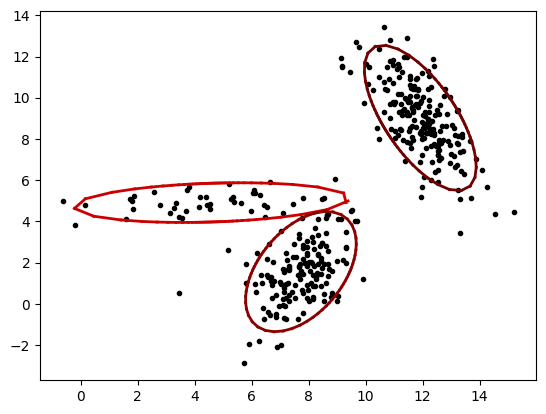

In [13]:
#define number of components to estimate
nGaussEst = 3

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#TO DO fill in this routine (below)
mixGaussEst = fitMixGauss(data,nGaussEst);

In [14]:
def load_data(imgs, gts):
    '''load rgb images and ground truths; and
    calculate the prior for the likelihood
    '''
    data_true = []
    data_false = []
    for img, gt in zip(imgs, gts):
        # load images
        image = plt.imread(img)
        image = image / 255
        # ground truth
        gtruth = (plt.imread(gt)[:,:,0]).astype(int) # only needs one channel
        for i in range(gtruth.shape[0]):
            for j in range(gtruth.shape[1]):
                if gtruth[i, j] == 1.0:
                    data_true.append(image[i,j])
                else:
                    data_false.append(image[i,j])
    # reshape the data to d x n
    data_true = np.asarray(data_true).T
    data_false = np.asarray(data_false).T
    # calculate the prior
    pixels = data_false.shape[1] + data_true.shape[1]
    prior = [data_true.shape[1]/ pixels, data_false.shape[1]/ pixels]
    return data_true, data_false, prior